In [1]:
from ultralytics import YOLO
from dotenv import load_dotenv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import r2_score, mean_squared_error

load_dotenv(".env")
DIR_SRC = os.getenv('DIR_SRC')
DIR_DATA = os.getenv("DIR_DATA")
model_s1 = YOLO("out/yolo8n_study1.pt")
sns.set("notebook")

In [28]:
def read_counts(dir_labels):
    ls_txt = os.listdir(dir_labels)
    ls_txt = [os.path.join(dir_labels, f) for f in ls_txt]
    ls_txt.sort()
    ls_filenames = [os.path.splitext(f)[0] for f in ls_txt]
    ls_filenames = [os.path.basename(f) for f in ls_filenames]
    ls_counts = []
    for f in ls_txt:
        with open(f, "r") as file:
            lines = file.readlines()
            ls_counts += [len(lines)]
    return ls_counts, ls_filenames

def r_rmse(df):
    # correlation r
    cor = df["obs"].corr(df["pre"])
    rmse = mean_squared_error(df["obs"], df["pre"], squared=False)
    rmspe = rmse / df["obs"].mean()
    return cor**2, rmse, rmspe

In [3]:
dir_pre_s1 = os.path.join(DIR_SRC, "runs", "detect")
dir_obs_s1 = os.path.join(DIR_DATA, "study1")
ls_test_s1 = ["test_a01", "test_a02", "test_a03", "test_b01", "test_b02"]

Generate predictions

In [ ]:
for t in ls_test_s1:
    dir_t = os.path.join(dir_obs_s1, t, "images")
    model_s1.predict(dir_t, device="mps", 
                save=True,
                show_conf=False,
                line_width=2,
                show_labels=False,
                save_txt=True,
                name=t,)

Organize pres and obs

In [6]:
df_s1 = pd.DataFrame(columns=["obs", "pre", "filename", "study", "split"])
for t in ls_test_s1:
    ls_obs, ls_obs_f = read_counts(os.path.join(dir_obs_s1, t, "labels"))
    df_obs = pd.DataFrame({"obs": ls_obs, "filename": ls_obs_f})
    
    ls_pre, ls_pre_f = read_counts(os.path.join(dir_pre_s1, t, "labels"))
    df_pre = pd.DataFrame({"pre": ls_pre, "filename": ls_pre_f})

    df_temp = pd.merge(df_obs, df_pre, on="filename", how="inner")
    df_temp["study"] = "s1"
    df_temp["split"] = t
    df_s1 = pd.concat([df_s1, df_temp])
df_s1.to_csv("out/df_s1.csv", index=False)

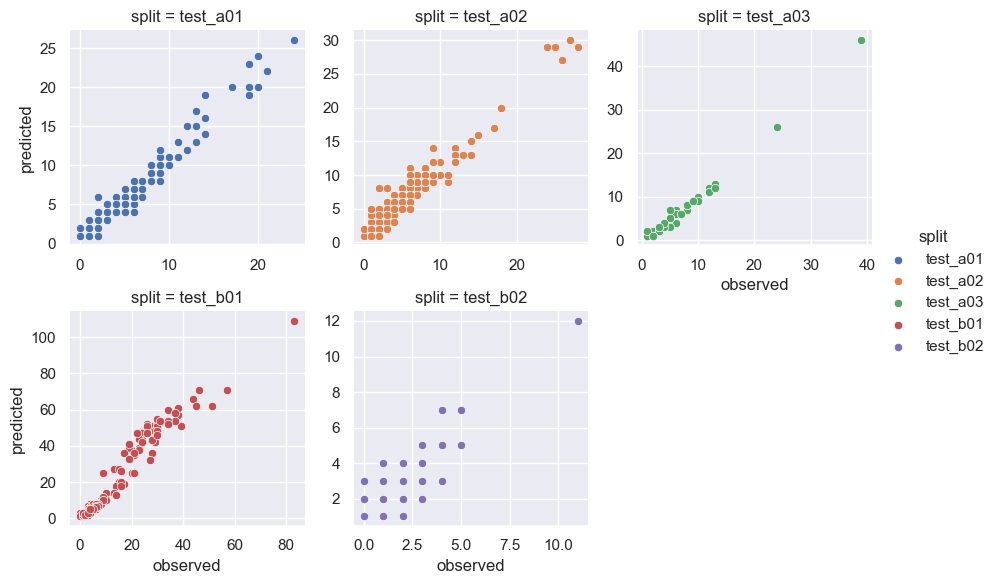

In [25]:
# facet grid
g = sns.FacetGrid(df_s1, col="split", col_wrap=3,
                  hue="split", sharex=False, sharey=False)
g.map(sns.scatterplot, "obs", "pre")
g.set_axis_labels("observed", "predicted")
# plot diagonal line for each facet
g.add_legend()
plt.savefig("out/plot_s1.png", dpi=300)

In [30]:
for s in ls_test_s1:
    df_temp = df_s1.query(f"split == '{s}'")
    r2, rmse, rmspe = r_rmse(df_temp)
    print(f"{s}: r2={r2:.2f}, rmse={rmse:.2f}, rmspe={rmspe:.2f}")

test_a01: r2=0.96, rmse=0.96, rmspe=0.19
test_a02: r2=0.94, rmse=1.55, rmspe=0.35
test_a03: r2=0.98, rmse=1.23, rmspe=0.19
test_b01: r2=0.95, rmse=11.36, rmspe=0.83
test_b02: r2=0.58, rmse=1.50, rmspe=1.62


/opt/homebrew/Caskroom/miniconda/base/envs/pyniche/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/pyniche/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/pyniche/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/pyniche/lib/python3.11/site-packages/sklearn/metrics/_reg